In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import networkx as nx
from collections import Counter


# Add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from collections import defaultdict
import numpy as np
import matplotlib.colors as mcolors
import seaborn as sns

import matplotlib.pyplot as plt

/tmp/ipykernel_270885/3217313760.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [17]:
comments_df = pd.read_csv(Path('../data/processed/youtube_comments_luther_processed.csv'))
videos_df = pd.read_csv(Path('../data/raw/youtube_videos_luther.csv'))

## Network Analysis

In [3]:
# Import network utils
from analyzers.network_creator import NetworkCreator
from analyzers.network_analyzer import NetworkAnalyzer

# Reload network analyzer and creator for changes

network_creator = NetworkCreator()
network_analyzer = NetworkAnalyzer()

### Comments Network

In [49]:
comments_network = network_creator.create_comment_reply_network(data=comments_df)

In [50]:
network_analyzer.compute_network_metrics(comments_network, centrality_metrics=False)

{'num_nodes': 13671,
 'num_edges': 11279,
 'density': 6.035340802515719e-05,
 'num_components': 280,
 'largest_component_size': 8735,
 'average_clustering': 0.005197591580210949,
 'transitivity': 0.00029206077007582864}

#### Create weighted graph

In [51]:
# Create a weighted directed graph
G_replies = nx.DiGraph()

# Get reply edges from the comments network
reply_edges = [(u, v) for u, v in comments_network.edges()]

# Calculate edge weights based on number of replies between users
edge_weights = Counter(reply_edges)

# Create weighted graph with edge weights
G_replies = nx.DiGraph()
for edge, weight in edge_weights.items():
    G_replies.add_edge(edge[0], edge[1], weight=weight)

# Get communities using Louvain method
communities = nx.community.louvain_communities(G_replies.to_undirected())
communities = {node: i for i, comm in enumerate(communities) for node in comm}

#### Visualization

/tmp/ipykernel_256515/2898925382.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(communities.values()) + 1)
/tmp/ipykernel_256515/2898925382.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/projects/music-social-network-analysis/music_yt_analysis_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from current font.
  func(*args, **kwargs)
/home/projects/music-social-network-analysis/music_yt_analysis_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  func(*args, **kwargs)
/home/projects/music-social-network-analysis/music

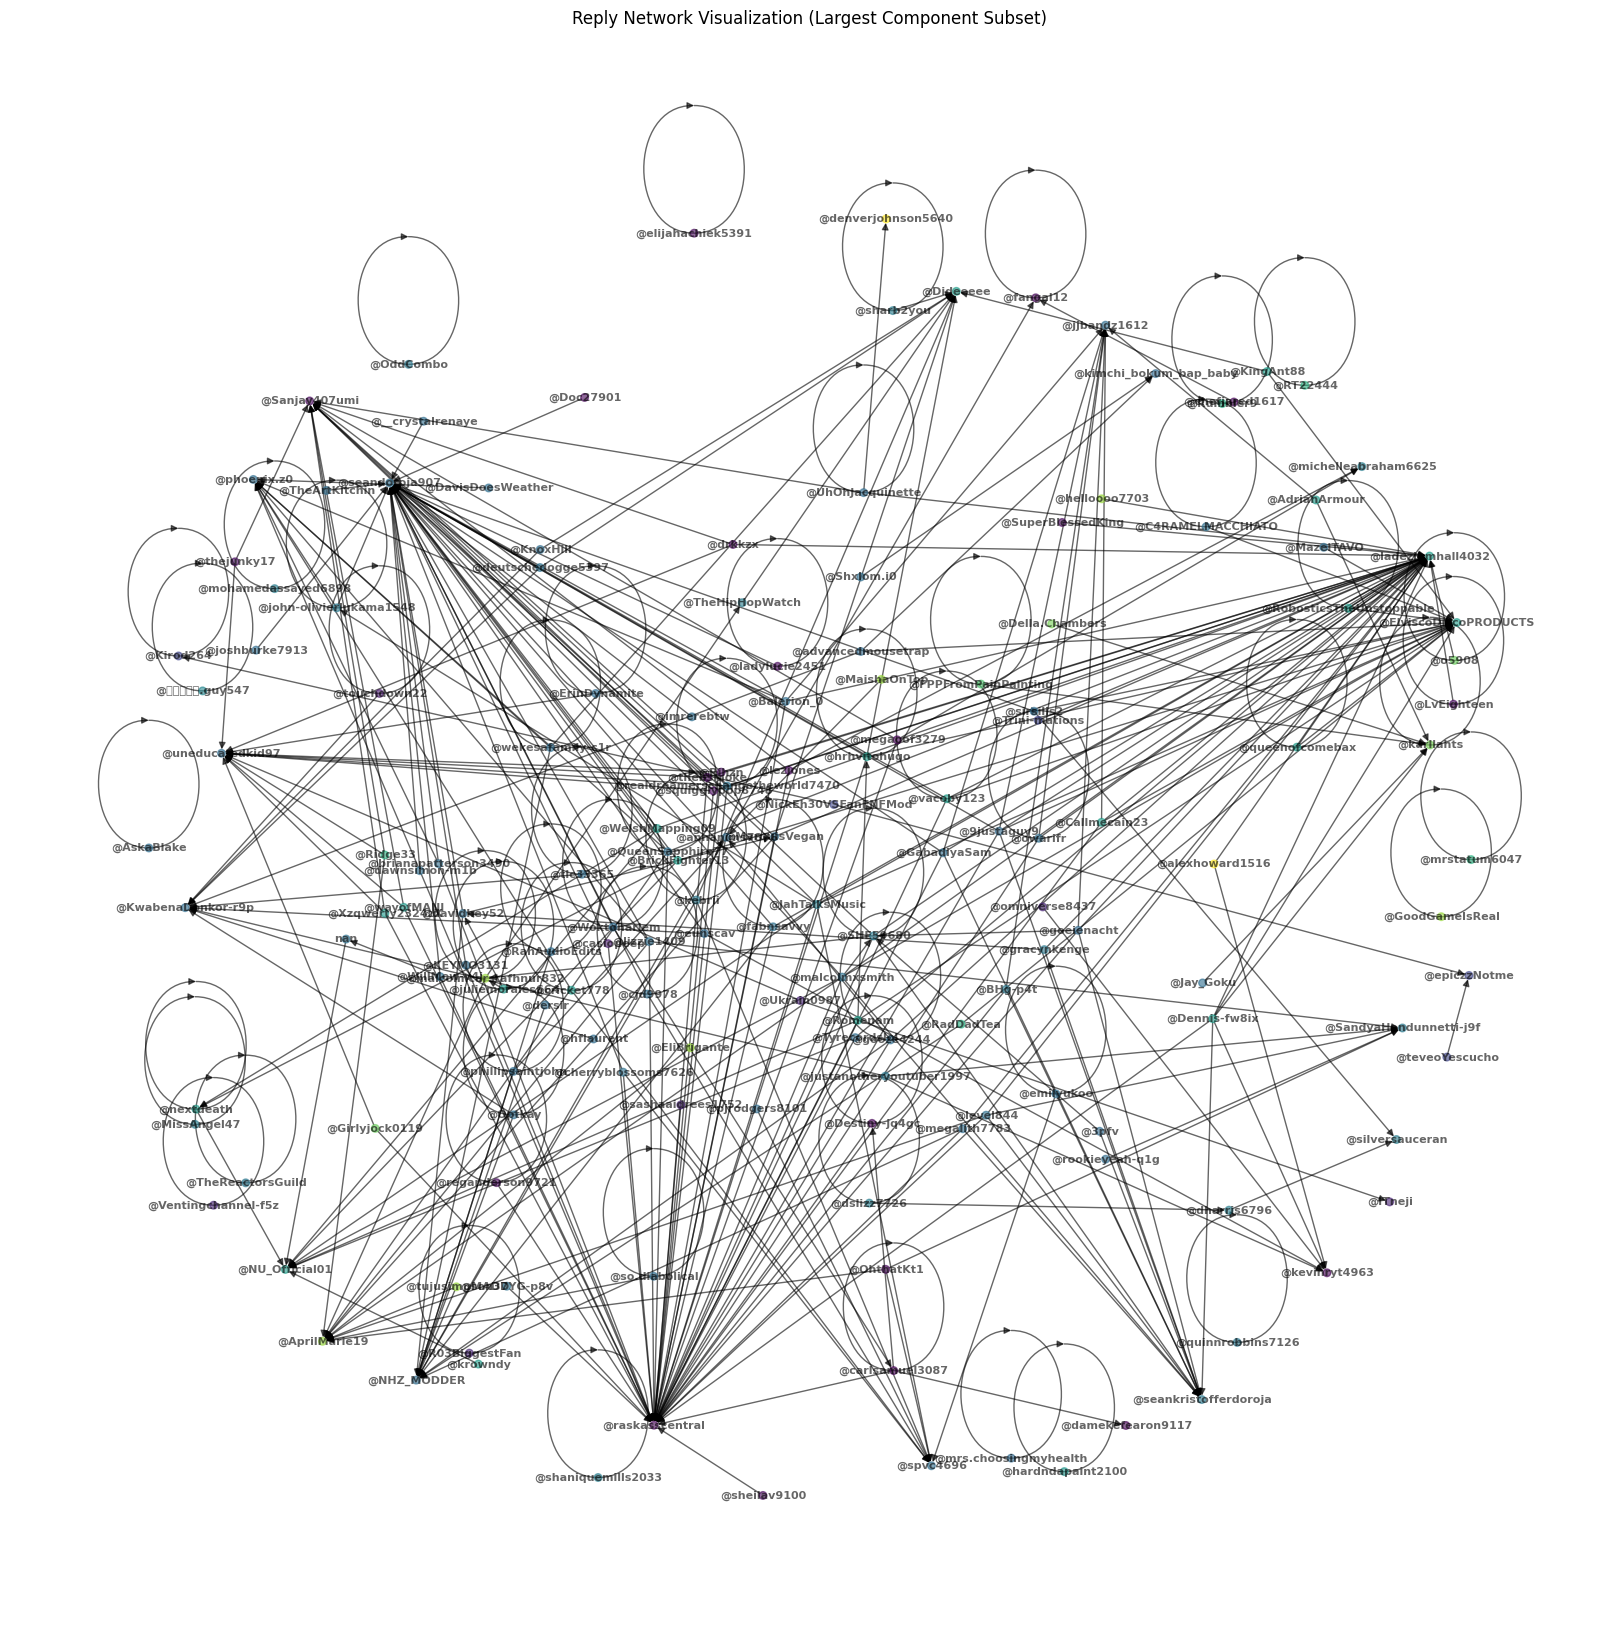

In [52]:
# Create a subgraph of the largest connected component for visualization
largest_cc = max(nx.weakly_connected_components(G_replies), key=len)
G_sub = G_replies.subgraph(largest_cc).copy()

# If the graph is still too large, take only the top nodes by degree
if G_sub.number_of_nodes() > 200:
    degrees = dict(G_sub.degree())
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:200]
    G_sub = G_sub.subgraph(top_nodes).copy()


# Create a simple layout using NetworkX with adjusted parameters
nx_graph = nx.DiGraph()
nx_graph.add_edges_from(G_sub.edges())


# Set node colors based on communities
node_colors = [communities.get(node, 0) for node in nx_graph.nodes()]

# Set node sizes based on in-degree centrality
in_degree = nx.in_degree_centrality(G_sub)
node_sizes = [5000 * in_degree.get(node, 0) + 50 for node in nx_graph.nodes()]

# Set edge widths based on weight
edge_widths = [G_sub[u][v].get('weight', 1) for u, v in nx_graph.edges()]


# Use spring layout with adjusted parameters for better spacing
pos = nx.spring_layout(
    nx_graph,
    k=0.3,  # Increased repulsion between nodes
    iterations=50,  # More iterations for better layout
    seed=42  # For reproducibility
)

# Plot the graph
plt.figure(figsize=(16, 16))
plt.clf()  # Clear any existing plots to avoid position errors
cmap = plt.cm.get_cmap('viridis', max(communities.values()) + 1)
nx.draw(
    nx_graph,
    pos=pos,
    node_size=30,  # Smaller nodes
    node_color=node_colors,
    cmap=cmap,
    arrows=True,
    arrowsize=10,  # Smaller arrows
    alpha=0.6,
    width=edge_widths,  # Thinner edges
    with_labels=True,  # Show node labels
    font_size=8,  # Small font size for readability
    font_color='black',  # Black text for visibility
    font_weight='bold'  # Make labels bold to stand out
)
plt.title('Reply Network Visualization (Largest Component Subset)')
plt.axis('off')
plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'reply_network.png'), dpi=300)

### Videos network

In [53]:
video_comment_network = network_creator.create_video_comment_network(comments_df)

In [54]:
network_analyzer.compute_network_metrics(video_comment_network, centrality_metrics=False)

{'num_nodes': 13686,
 'num_edges': 14642,
 'density': 7.81770116124524e-05,
 'num_components': 1,
 'largest_component_size': 13686,
 'average_clustering': 0.0,
 'transitivity': 0}

In [55]:
# Create a filtered version of the video-comment network
filtered_network = nx.DiGraph()

# Get all nodes and their attributes
nodes_data = dict(video_comment_network.nodes(data=True))

# First identify authors connected to multiple videos
author_connections = defaultdict(set)
for edge in video_comment_network.edges():
    author, video = edge  # Swap order since edges point from author to video
    if nodes_data[author]['type'] == 'author':
        author_connections[author].add(video)

# Get authors with multiple videos
multi_video_authors = {
    author for author, videos in author_connections.items() 
    if len(videos) > 1
}

# Get all single-video authors
single_video_authors = {
    author for author, videos in author_connections.items()
    if len(videos) == 1
}

# Randomly select 10% of single-video authors
num_to_keep = max(1, int(len(single_video_authors) * 0.1))
single_video_authors_to_keep = set(np.random.choice(
    list(single_video_authors),
    size=num_to_keep,
    replace=False
))

# Add all video nodes
videos = [node for node, attr in nodes_data.items() if attr['type'] == 'video']
for video in videos:
    filtered_network.add_node(video, **nodes_data[video])

# Add selected author nodes and their edges
authors_to_keep = multi_video_authors | single_video_authors_to_keep

for author in authors_to_keep:
    # Add author node
    filtered_network.add_node(author, **nodes_data[author])
    
    # Add edges for this author
    for video in author_connections[author]:
        filtered_network.add_edge(author, video)  # Edge now points from author to video

In [ ]:
# Replace the original network with filtered version
video_comment_network = filtered_network

#### Visualization of video network

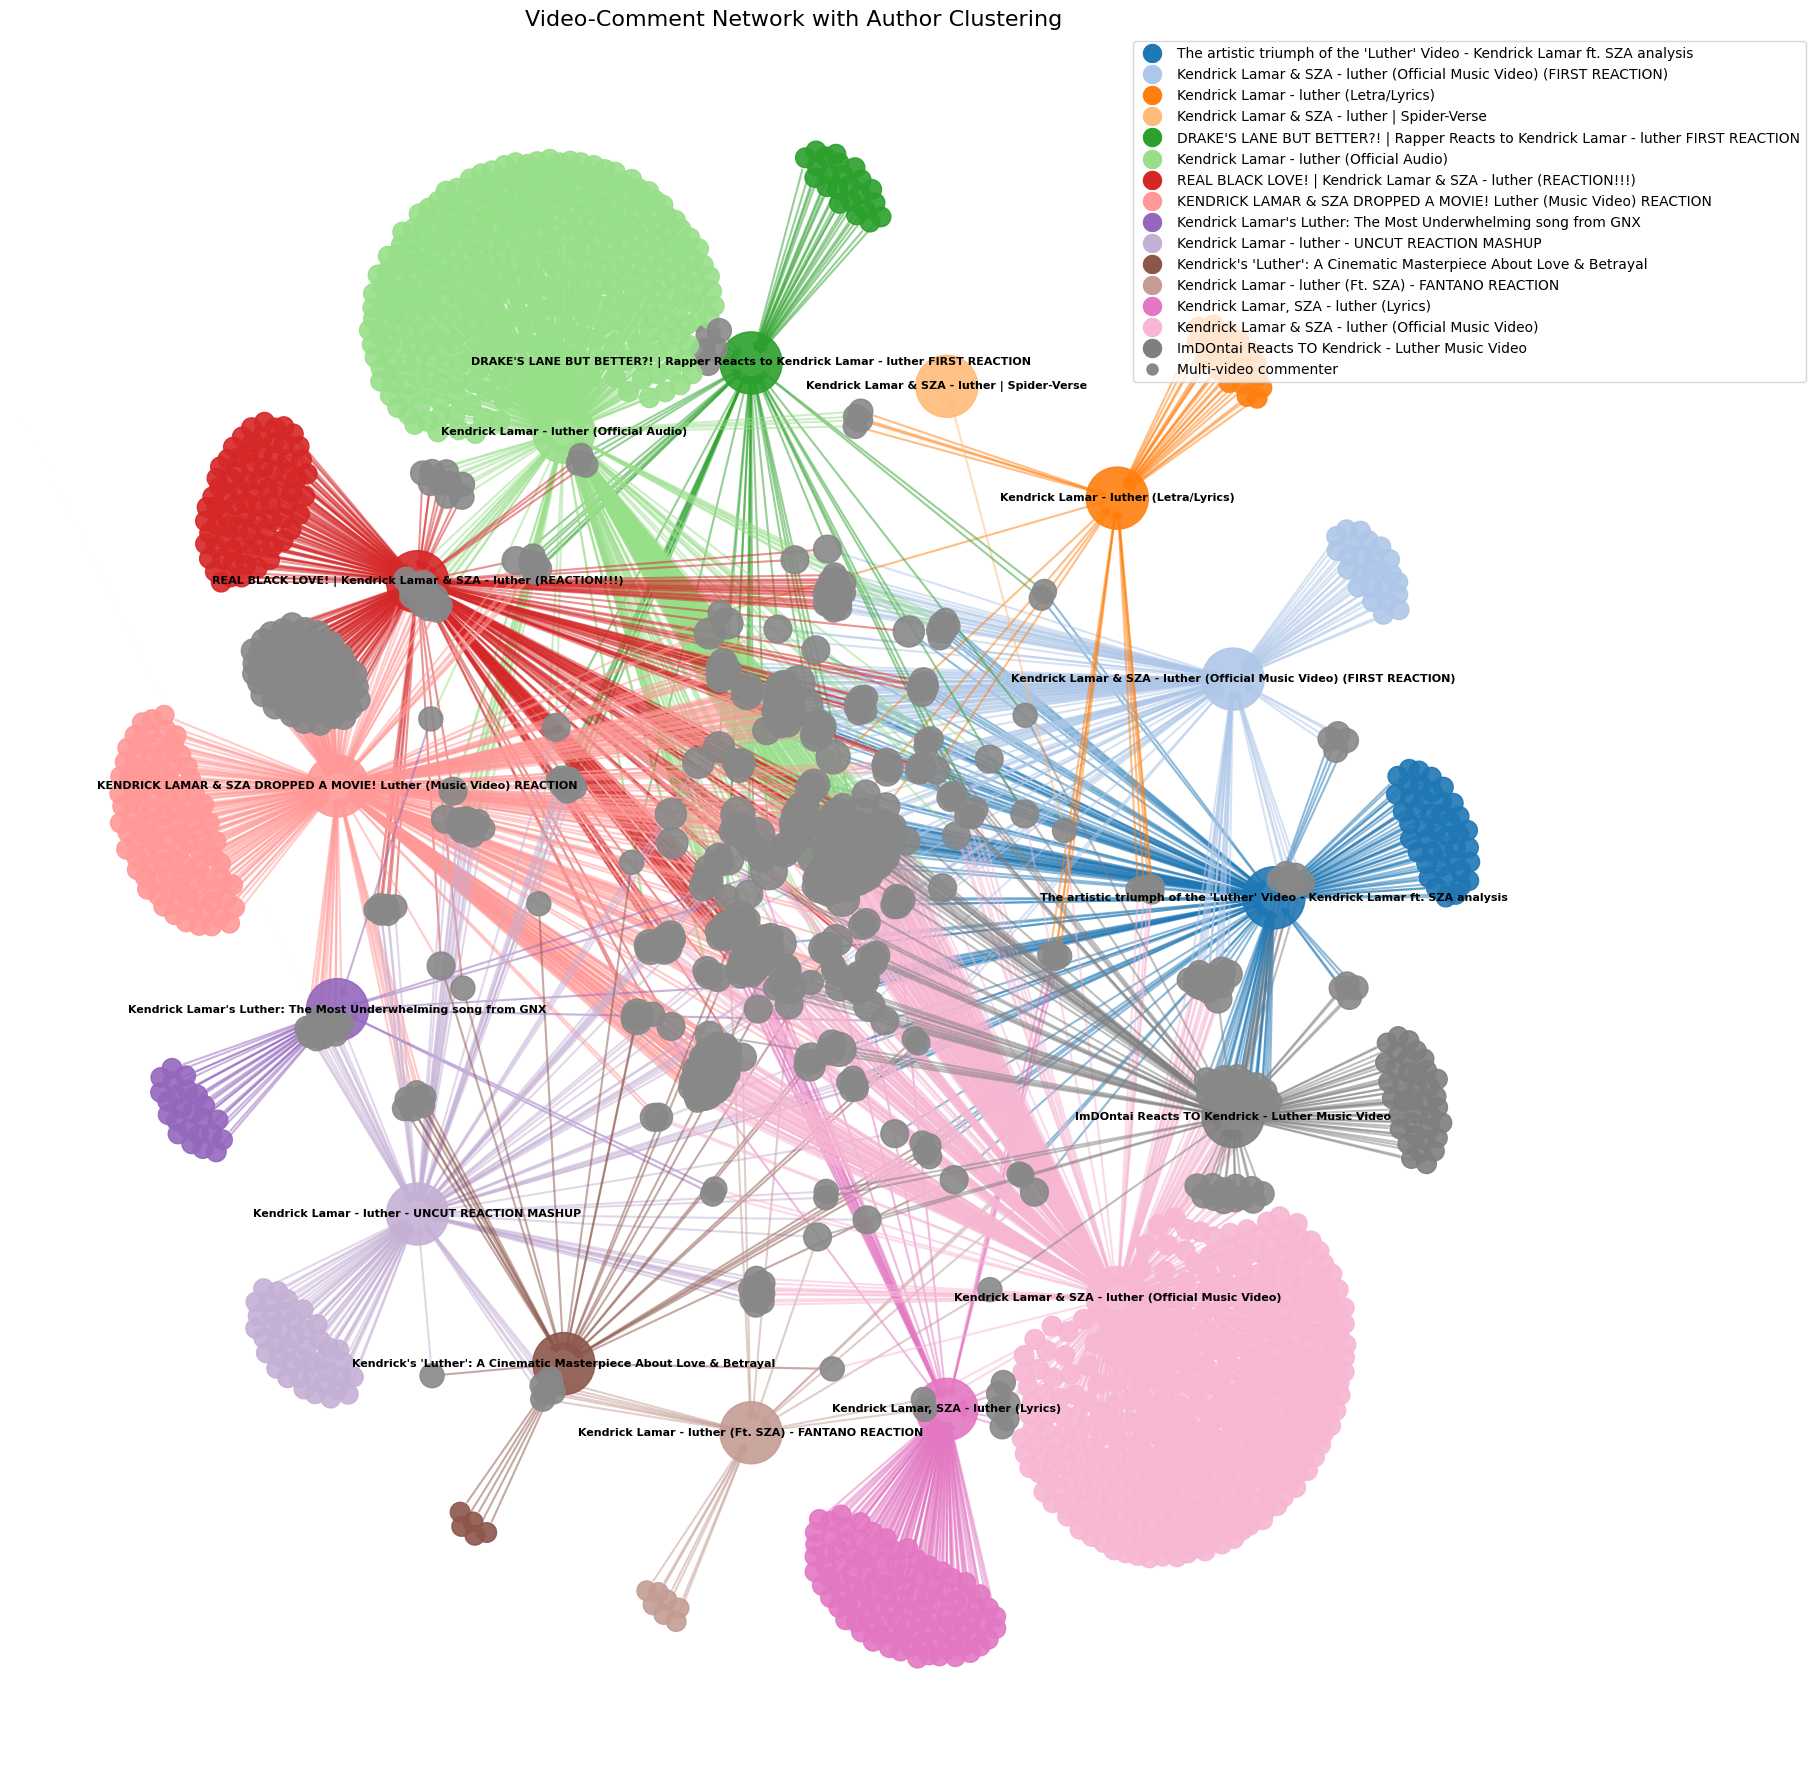

In [56]:


# --- Color palette for video nodes ---
video_nodes = [n for n, d in filtered_network.nodes(data=True) if d['type'] == 'video']
comment_nodes = [n for n, d in filtered_network.nodes(data=True) if d['type'] != 'video']

palette = sns.color_palette("tab20", len(video_nodes))
video_colors = {video: mcolors.to_hex(color) for video, color in zip(video_nodes, palette)}
video_light_colors = {
    video: mcolors.to_hex(mcolors.to_rgba(color, alpha=0.3))
    for video, color in video_colors.items()
}

# --- Fix video node positions far from each other ---
video_pos = nx.circular_layout(video_nodes, scale=10.0)

# --- Build initial positions dictionary ---
init_pos = video_pos.copy()

# --- Calculate video-centered layout for comments ---
# Group by connected videos
from collections import defaultdict

comment_video_groups = defaultdict(list)
for node in comment_nodes:
    targets = tuple(sorted([t for t in filtered_network.successors(node) if t in video_nodes]))
    comment_video_groups[targets].append(node)

# Apply spring layout only to comment nodes, video nodes fixed
pos = nx.spring_layout(
    filtered_network,
    pos=init_pos,
    fixed=video_nodes,
    k=0.5,
    iterations=100,
    seed=42
)

# --- Compute node styles ---
node_colors = []
node_sizes = []
labels = {}

for node in filtered_network.nodes():
    node_type = filtered_network.nodes[node]['type']
    if node_type == 'video':
        color = video_colors[node]
        node_colors.append(color)
        node_sizes.append(2000)
        labels[node] = filtered_network.nodes[node].get('title', '')
    else:
        # Authors/comments
        targets = tuple(sorted([t for t in filtered_network.successors(node) if t in video_nodes]))
        degree = len(targets)
        if degree == 1:
            node_colors.append(video_light_colors[targets[0]])  # color of target video (light)
        else:
            node_colors.append("#888888")  # neutral gray for multi-target authors
        node_sizes.append(100 + 100 * degree)  # larger for more edges
        labels[node] = ''  # optional: comment ID or empty

# --- Draw edges grouped by target video (for color) ---
plt.figure(figsize=(18, 18))
plt.clf()

# Draw edges grouped by video
for video in video_nodes:
    in_edges = [(n1, n2) for n1, n2 in filtered_network.edges() if n2 == video]
    nx.draw_networkx_edges(
        filtered_network,
        pos,
        edgelist=in_edges,
        edge_color=video_light_colors[video],
        alpha=0.5,
        width=1.5
    )

# Draw rest of the edges (e.g. comment -> comment if any)
other_edges = [(u, v) for u, v in filtered_network.edges() if v not in video_nodes]
nx.draw_networkx_edges(filtered_network, pos, edgelist=other_edges, alpha=0.2, width=0.5)

# Draw nodes and labels
nx.draw_networkx_nodes(filtered_network, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_labels(filtered_network, pos, labels=labels, font_size=8, font_weight='bold')

# Title and legend
plt.title('Video-Comment Network with Author Clustering', fontsize=16)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color, markersize=15, label=filtered_network.nodes[v]['title'])
    for v, color in video_colors.items()
]
legend_elements.append(
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor="#888888", markersize=10, label="Multi-video commenter")
)

plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
plt.axis('off')
plt.tight_layout()
# plt.savefig("video_comment_network.png", dpi=300)
plt.show()


In [62]:
# Find author nodes that commented on multiple videos
multi_video_authors = [
    node for node in filtered_network.nodes()
    if node not in video_nodes and len(set(
        target for _, target in filtered_network.edges(node)
        if target in video_nodes
    )) > 1
]

# Create lists to store the data
data = []
for author in multi_video_authors:
    author_videos = []
    author_comments = []
    
    for _, video in filtered_network.edges(author):
        if video in video_nodes:
            video_title = filtered_network.nodes[video]['title']
            # Get comment text from comments_df instead of network
            author_comments_for_video = comments_df[
                (comments_df['author'] == author) & 
                (comments_df['video_title'] == video_title)
            ]['text'].values
            
            if len(author_comments_for_video) > 0:
                author_videos.append(video_title)
                author_comments.append(author_comments_for_video[0])
    
    # Add a row for each video the author commented on
    for video, comment in zip(author_videos, author_comments):
        data.append({
            'author': author,
            'video_title': video,
            'comment_text': comment
        })

# Create DataFrame
multi_video_comments_df = pd.DataFrame(data)

# Display summary and DataFrame
print(f"\nFound {len(multi_video_authors)} authors who commented on multiple videos\n")
display(multi_video_comments_df)


Found 752 authors who commented on multiple videos



author                                        video_title  \
0     @feliciadavis881  Kendrick Lamar & SZA - luther (Official Music ...   
1     @feliciadavis881  KENDRICK LAMAR & SZA DROPPED A MOVIE! Luther (...   
2         @THEVERANO21           Kendrick Lamar - luther (Official Audio)   
3         @THEVERANO21  Kendrick Lamar & SZA - luther (Official Music ...   
4           @sammc2601           Kendrick Lamar - luther (Official Audio)   
...                ...                                                ...   
1716          @BLxM559  Kendrick Lamar & SZA - luther (Official Music ...   
1717          @BLxM559  KENDRICK LAMAR & SZA DROPPED A MOVIE! Luther (...   
1718          @BLxM559  The artistic triumph of the 'Luther' Video - K...   
1719    @jadavella4623  Kendrick Lamar & SZA - luther (Official Music ...   
1720    @jadavella4623  REAL BLACK LOVE! | Kendrick Lamar & SZA - luth...   

                                           comment_text  
0     video cinematic soulful love ❤❤grown folk music 🎶  
1                     video cinematic soulful iove it❤❤  
2                                              sza sent  
3                                                   NaN  
4                       damn. hang there. stay get out.  
...                                                 ...  
1716                sza working girl that’s drake wanna  
1717              look like sza working girl. tripping?  
1718                sza working girl that’s drake wanna  
1719                       sza look amazing red hair 💯🔥  
1720                                    luther banger 🔥  

[1721 rows x 3 columns]

In [63]:
multi_video_comments_df.to_csv(Path('../data/processed/multi_video_comments_luther.csv'), index=False)

### Categorical Network

In [18]:
categorical_comment_network = network_creator.create_category_network(comments_df)

In [19]:
network_analyzer.compute_network_metrics(categorical_comment_network, centrality_metrics=False)

{'num_nodes': 13689,
 'num_edges': 14655,
 'density': 7.821212807051048e-05,
 'num_components': 1,
 'largest_component_size': 13689,
 'average_clustering': 0.0,
 'transitivity': 0}

In [20]:
# Get author nodes that appear multiple times
author_nodes = [node for node, data in categorical_comment_network.nodes(data=True) 
                if data.get('type') == 'author']

# Count videos per author
author_video_counts = {}
for author in author_nodes:
    # Get all edges from this author
    author_edges = list(categorical_comment_network.edges(author))
    author_video_counts[author] = len(author_edges)

# Filter to authors with multiple videos
multi_video_authors = [author for author, count in author_video_counts.items() 
                      if count > 1]

# Get single video authors
single_video_authors = [author for author, count in author_video_counts.items()
                       if count == 1]

# Keep all multi-video authors and 10% of single video authors
num_single_to_keep = max(1, int(len(single_video_authors) * 0.1))
authors_to_keep = multi_video_authors + single_video_authors[:num_single_to_keep]

# Create subgraph with only selected authors
filtered_network = categorical_comment_network.copy()

# Remove non-selected authors
authors_to_remove = [author for author in author_nodes 
                    if author not in authors_to_keep]
filtered_network.remove_nodes_from(authors_to_remove)




In [21]:
# Update the network for visualization
categorical_comment_network = filtered_network

/home/projects/music-social-network-analysis/music_yt_analysis_env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/tmp/ipykernel_270885/4096508749.py:59: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(nx_graph, pos,


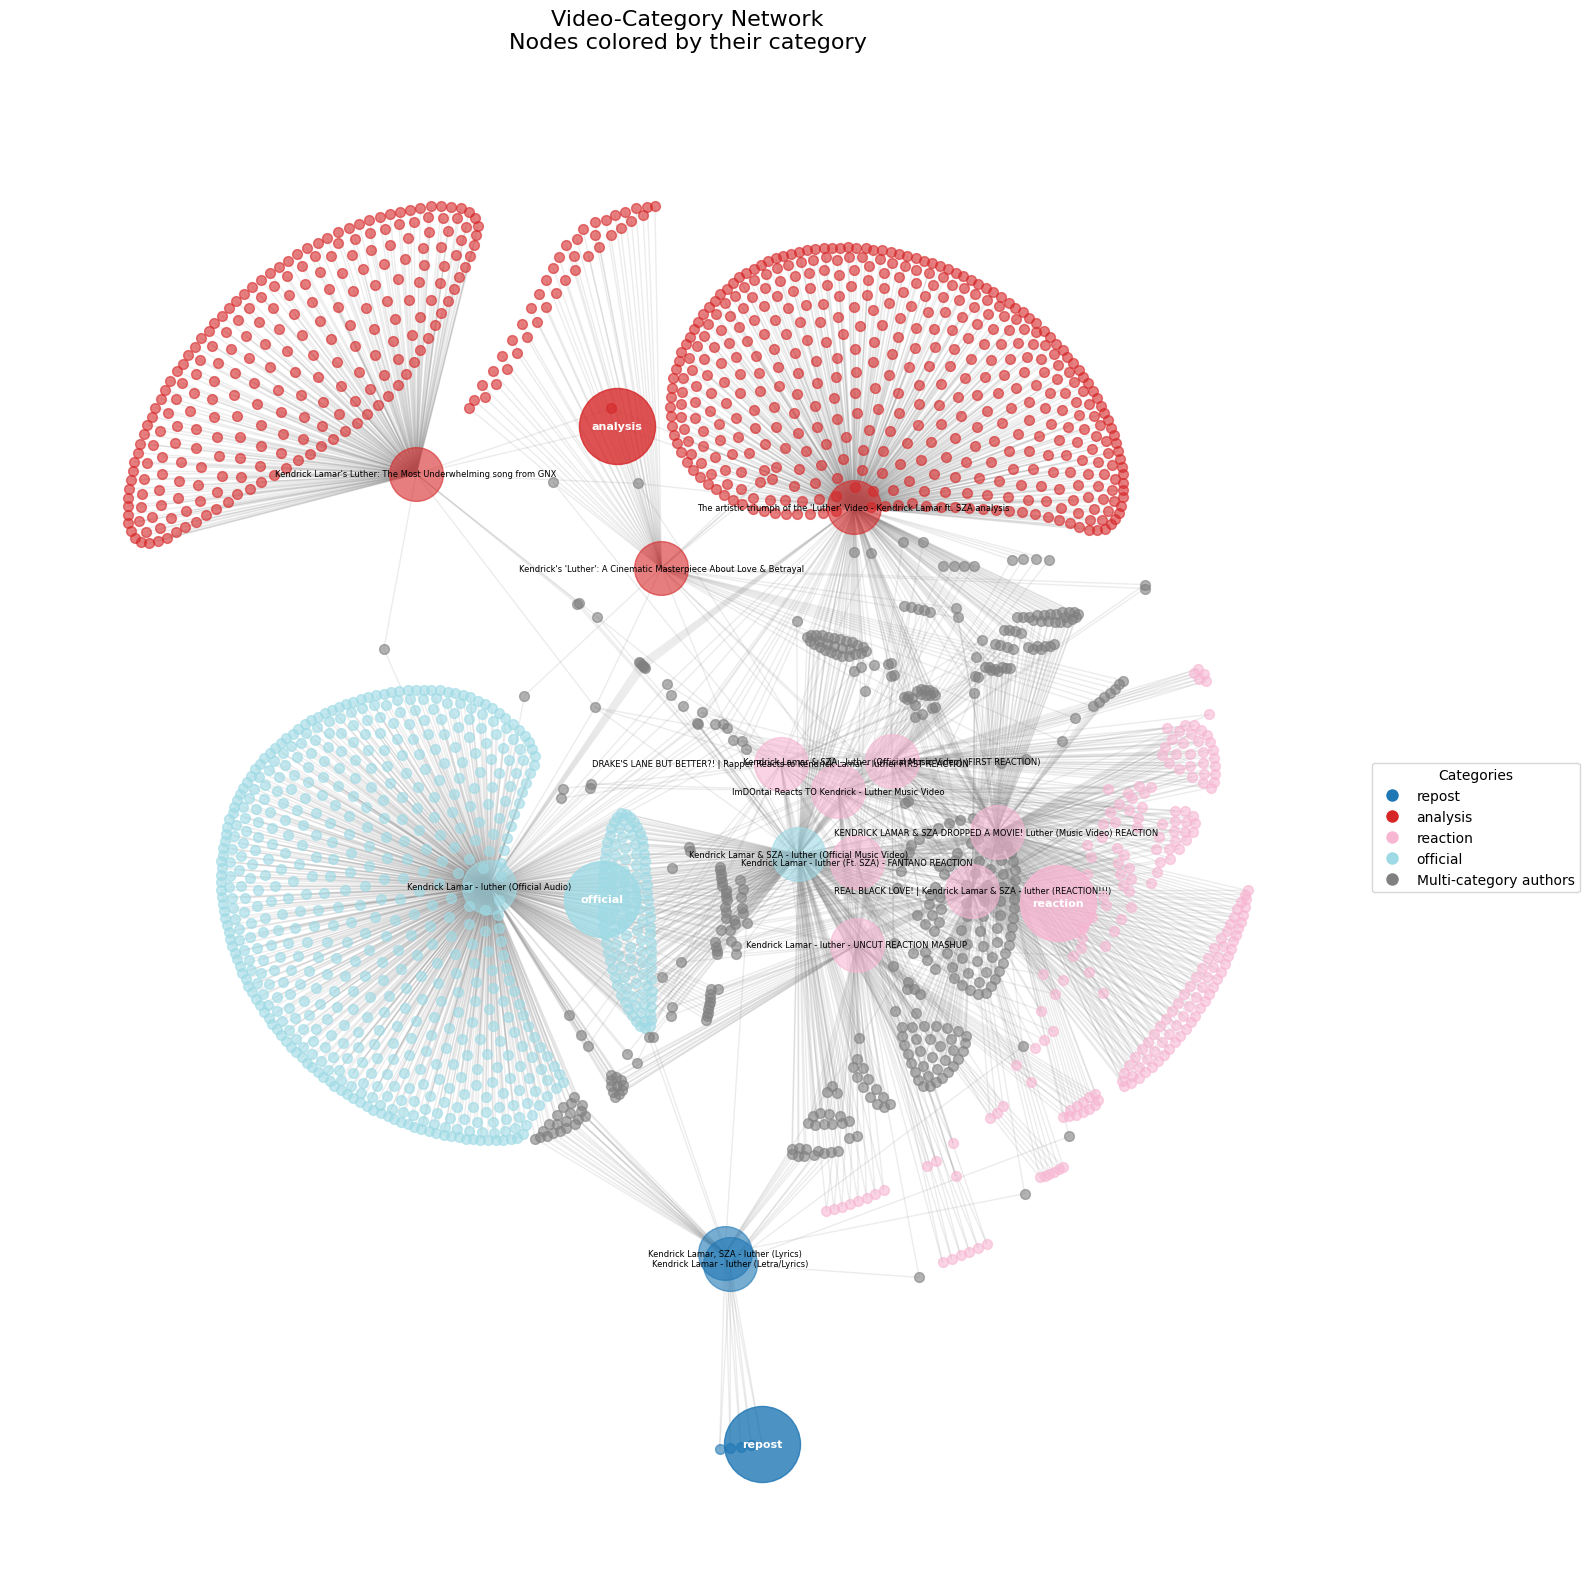

In [22]:
# Convert to NetworkX graph for visualization
nx_graph = nx.Graph(categorical_comment_network)

# Get node positions using kamada_kawai_layout since spring_layout had issues
pos = nx.kamada_kawai_layout(nx_graph)

# Set up the plot with a white background
plt.figure(figsize=(16, 16), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')

# Get all unique categories to assign colors
categories = list({data['category'] for _, data in 
                  nx_graph.nodes(data=True) 
                  if 'category' in data})
cmap = plt.colormaps['tab20'](np.linspace(0, 1, len(categories)))
category_colors = {cat: cmap[i] for i, cat in enumerate(categories)}

# Draw nodes
for node, data in nx_graph.nodes(data=True):
    if 'type' in data:
        if data['type'] == 'category':
            # Draw category nodes largest and in their category color
            node_color = category_colors[node]  # Category name is the node ID
            nx.draw_networkx_nodes(nx_graph, pos,
                                 nodelist=[node],
                                 node_color=[node_color],
                                 node_size=3000,
                                 alpha=0.8)
        elif data['type'] == 'video':
            # Draw video nodes in their category color
            node_color = category_colors[data['category']]
            nx.draw_networkx_nodes(nx_graph, pos,
                                 nodelist=[node],
                                 node_color=[node_color],
                                 node_size=1500,
                                 alpha=0.6)
        else:  # author nodes
            # Get connected videos
            neighbors = list(nx_graph.neighbors(node))
            video_categories = [nx_graph.nodes[v]['category'] 
                              for v in neighbors 
                              if nx_graph.nodes[v]['type'] == 'video']
            
            if len(set(video_categories)) == 1:
                # Single category - use that color
                node_color = category_colors[video_categories[0]]
            else:
                # Multiple categories - use grey
                node_color = 'grey'
                
            nx.draw_networkx_nodes(nx_graph, pos,
                                 nodelist=[node],
                                 node_color=node_color,
                                 node_size=50,
                                 alpha=0.6)

# Draw edges with curved arrows
nx.draw_networkx_edges(nx_graph, pos,
                      alpha=0.15, 
                      edge_color='gray',
                      connectionstyle="arc3,rad=0.2")

# Add labels for category nodes and video nodes
category_labels = {node: node for node, data in 
                  nx_graph.nodes(data=True)
                  if data.get('type') == 'category'}
video_labels = {node: data['title'] for node, data in 
                nx_graph.nodes(data=True)
                if data.get('type') == 'video'}

# Draw category labels with white text
nx.draw_networkx_labels(nx_graph, pos,
                       labels=category_labels,
                       font_size=8,
                       font_weight='bold',
                       font_color='white')

# Draw video labels with smaller black text
nx.draw_networkx_labels(nx_graph, pos,
                       labels=video_labels, 
                       font_size=6,
                       font_color='black')

# Add a legend for categories
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=cat, markersize=10)
                  for cat, color in category_colors.items()]
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor='grey', 
                                label='Multi-category authors',
                                markersize=10))
plt.legend(handles=legend_elements, 
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          title="Categories")

plt.title("Video-Category Network\nNodes colored by their category", 
          fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

### Topic Network